In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split

import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import numpy as np
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
SEED = 28091997

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


# Phân tích dữ liệu

In [4]:
train_df = pd.read_csv("./data/kaggle/train.csv")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
# Xóa nan
train_df.dropna(inplace=True)

Vẽ đồ thị số từ của cả 2 câu hỏi

In [6]:
train_sentences_lens = train_df['question1'].apply(lambda x: len(x.split(' '))).tolist()

train_sentences_lens.extend(train_df['question2'].apply(lambda x: len(x.split(' '))).tolist())

/home/thang/env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

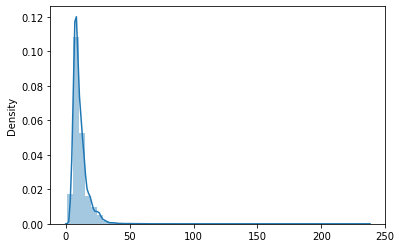

In [7]:
sns.distplot(train_sentences_lens)

In [8]:
MAX_LEN = 40

In [9]:
train_df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

<AxesSubplot:ylabel='Frequency'>

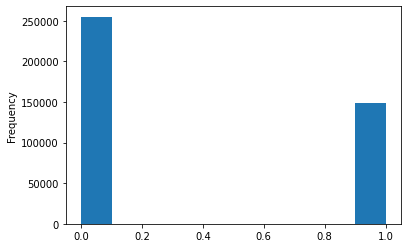

In [10]:
# Xem phân phối pos và neg
train_df.is_duplicate.plot.hist()

In [11]:
# Kiểm tra xem có cặp câu hỏi nào bị trùng trong dữ liệu không
duplicate_rows = train_df[train_df.duplicated(['qid1', 'qid2'])]
print("Number of duplicate questions:", len(duplicate_rows))

Number of duplicate questions: 0


In [12]:
# Số từ chung giữa question1 và question2 chia cho tổng số từ cả 2 câu
def shared_words(row):
    q1_word_set = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    q2_word_set = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
    return 1.0*len(q1_word_set & q2_word_set)/(len(q1_word_set)+len(q2_word_set))

In [13]:
train_df['shared_words'] = train_df.apply(shared_words, axis=1)

In [14]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,shared_words
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.434783
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,0.200000
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,0.166667
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,0.000000
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,0.100000


/home/thang/env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/thang/env/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


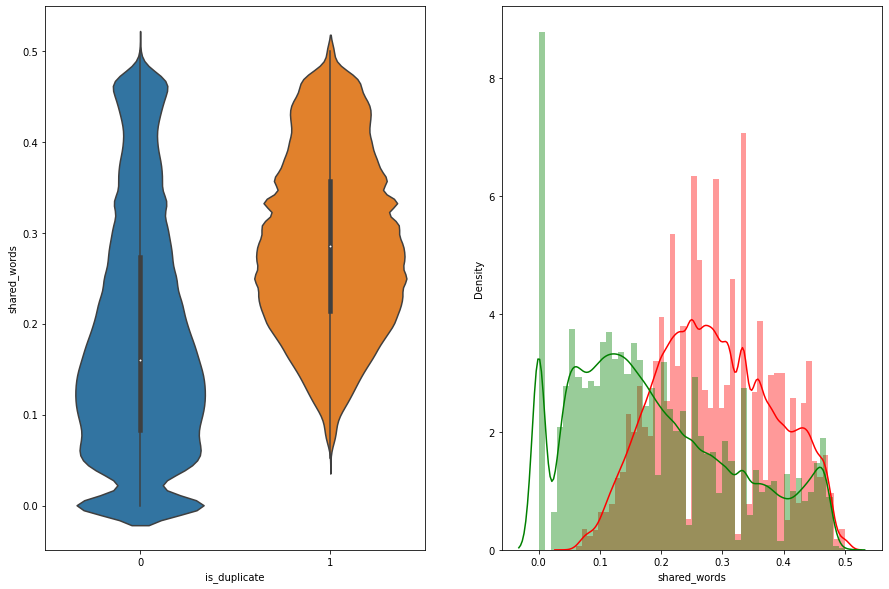

In [15]:
plt.figure(figsize=(15, 10))

plt.subplot(1,2,2)
sns.distplot(train_df[train_df['is_duplicate'] == 1]['shared_words'][0:] , label = "1", color = 'red')
sns.distplot(train_df[train_df['is_duplicate'] == 0]['shared_words'][0:] , label = "0" , color = 'green' )

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'shared_words', data = train_df[0:])

plt.show()

# Chuẩn bị dữ liệu

In [16]:
BERT_VERSION = 'bert-base-uncased'
POOLED_OUTPUT_DIM = 768

In [17]:
tokenizer = BertTokenizer.from_pretrained(BERT_VERSION)

In [18]:
# split train and validation set
train_df, val_df = train_test_split(train_df, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

In [19]:
class BertDataSet:
    def __init__(self, first_questions, second_questions, targets, tokenizer):
        self.first_questions = first_questions
        self.second_questions = second_questions
        self.targets = targets
        self.tokenizer = tokenizer
        self.length = len(first_questions)

    def __len__(self):
        return self.length

    def __getitem__(self, item):
        first_questions = str(self.first_questions[item])
        second_questions = str(self.second_questions[item])

        # remove extra white spaces from questions
        first_questions = " ".join(first_questions.split())
        second_questions = " ".join(second_questions.split())

        ### [CLS] question1 [SEP] question2 [SEP] ... [PAD]
        inputs = self.tokenizer.encode_plus(
            first_questions,
            second_questions,
            add_special_tokens=True,
            padding='max_length',
            max_length=2*MAX_LEN+3, # max length of 2 questions and 3 spectial tokens
            truncation=True
        )

        # return targets 0, when using data set in testing and targets are none
        return {
            "ids": torch.tensor(inputs["input_ids"], dtype=torch.long),
            "mask": torch.tensor(inputs["attention_mask"], dtype=torch.long),
            "token_type_ids": torch.tensor(inputs["token_type_ids"], dtype=torch.long),
            "targets": torch.tensor(int(self.targets[item]), dtype=torch.long) if self.targets is not None else 0
        }

In [20]:
# creates dataset and returns dataloader of it
def get_data_loader(df, targets, batch_size, shuffle, tokenizer):
    dataset = BertDataSet(
        first_questions=df["question1"].values,
        second_questions=df["question2"].values,
        targets=targets,
        tokenizer=tokenizer
    )

    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle=shuffle
    )

    return data_loader

In [21]:
BATCH_SIZE = 8

In [22]:
# create data loaders of training and validation data
train_data_loader = get_data_loader(
    df=train_df,
    targets=train_df["is_duplicate"].values,
    batch_size=BATCH_SIZE,
    shuffle=True,
    tokenizer=tokenizer
)

val_data_loader = get_data_loader(
    df=val_df,
    targets=val_df["is_duplicate"].values,
    batch_size=4*BATCH_SIZE,
    shuffle=True,
    tokenizer=tokenizer
)


# Model

In [23]:
class BertModel(nn.Module):
    def __init__(self, bert_path):
        super(BertModel, self).__init__()
        self.bert_path = bert_path
        self.bert = transformers.BertModel.from_pretrained(self.bert_path)
        self.dropout = nn.Dropout(0.3)
        self.out = nn.Linear(POOLED_OUTPUT_DIM, 1) # (768, 1)


    def forward(self, ids, mask, token_type_ids):
        _, pooled = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)

        # add dropout to prevent overfitting
        pooled = self.dropout(pooled)
        return self.out(pooled)

In [24]:
model = BertModel(BERT_VERSION).to(device)

# Training

In [25]:
# Loss function = binary cross entropy loss
# using sigmoid to put probabilities in [0,1] interval
def loss_fn(outputs, targets):
    outputs = torch.squeeze(outputs)
    return nn.BCELoss()(nn.Sigmoid()(outputs), targets)

In [26]:
def calculate_perplexity(data_loader, model, device):
    model.eval()
    # tells Pytorch not to store values of intermediate computations for backward pass because we not gonna need gradients
    with torch.no_grad():
        total_loss = 0
        for batch in data_loader:
            ids = batch["ids"].to(device, dtype=torch.long)
            mask = batch["mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.float)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            total_loss += loss_fn(outputs, targets).item()

    model.train()

    return np.exp(total_loss/len(data_loader)) 

In [27]:
def train_loop(epochs, train_data_loader, val_data_loader, model, optimizer, device, scheduler=None):
    it = 1
    total_loss = 0
    curr_perplexity = None
    perplexity = None
    
    model.train()
    for epoch in range(epochs):
        print('Epoch: ', epoch + 1)
        for batch in train_data_loader:
            ids = batch["ids"].to(device, dtype=torch.long)
            mask = batch["mask"].to(device, dtype=torch.long)
            token_type_ids = batch["token_type_ids"].to(device, dtype=torch.long)
            targets = batch["targets"].to(device, dtype=torch.float)

            optimizer.zero_grad()
            
            # do forward pass, will save intermediate computations of the graph for later backprop use.
            outputs = model(ids, mask=mask, token_type_ids=token_type_ids)
            
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            
            # running backprop.
            loss.backward()
            
            # doing gradient descent step.
            optimizer.step()
            
            # we are logging current loss/perplexity in every 100 iteration
            if it % 100 == 0:
                
                # computing validation set perplexity in every 500 iteration.
                if it % 500 == 0:
                    curr_perplexity = calculate_perplexity(val_data_loader, model, device)
                    
                    if scheduler is not None:
                        scheduler.step()

                    # making checkpoint of best model weights.
                    if not perplexity or curr_perplexity < perplexity:
                        torch.save(model.state_dict(), 'saved_model')
                        perplexity = curr_perplexity

                print('| Iter', it, '| Avg Train Loss', total_loss / 100, '| Dev Perplexity', curr_perplexity)
                total_loss = 0

            it += 1
   

In [28]:
def run(model, train_df, device, train_data_loader, val_data_loader):
    EPOCHS = 1
    
    lr = 3e-5
    num_training_steps = int(len(train_data_loader) * EPOCHS)
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )
    
    
    train_loop(EPOCHS, train_data_loader, val_data_loader,  model, optimizer, device, scheduler)

In [29]:
run(model, train_df, device, train_data_loader, val_data_loader)

Epoch:  1
| Iter 100 | Avg Train Loss 0.6196133252978325 | Dev Perplexity None
| Iter 200 | Avg Train Loss 0.5685822832584381 | Dev Perplexity None
| Iter 300 | Avg Train Loss 0.5517381435632706 | Dev Perplexity None
| Iter 400 | Avg Train Loss 0.4981609933078289 | Dev Perplexity None
| Iter 500 | Avg Train Loss 0.4851067738234997 | Dev Perplexity 1.5638666659765141
| Iter 600 | Avg Train Loss 0.46294011659920214 | Dev Perplexity 1.5638666659765141
| Iter 700 | Avg Train Loss 0.4668818706274033 | Dev Perplexity 1.5638666659765141
| Iter 800 | Avg Train Loss 0.47338620603084564 | Dev Perplexity 1.5638666659765141
| Iter 900 | Avg Train Loss 0.4742924854159355 | Dev Perplexity 1.5638666659765141
| Iter 1000 | Avg Train Loss 0.44770198777318 | Dev Perplexity 1.533744629300406
| Iter 1100 | Avg Train Loss 0.46929919622838495 | Dev Perplexity 1.533744629300406
| Iter 1200 | Avg Train Loss 0.4609019003808498 | Dev Perplexity 1.533744629300406
| Iter 1300 | Avg Train Loss 0.45777407228946687 

KeyboardInterrupt: 

# Testing

In [37]:
test_df = pd.read_csv("./data/kaggle/test.csv")
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [38]:
def test(model, test_df, device):
    predictions = torch.empty(0).to(device, dtype=torch.float)
    
    test_dataset = BertDataSet(
        first_questions=test_df["question1"].values,
        second_questions=test_df["question2"].values,
        targets=None,
        tokenizer=tokenizer
    )
    
    test_data_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=512
    )
    
    with torch.no_grad():
        model.eval()
        for batch in tqdm(test_data_loader):
            ids = batch["ids"]
            mask = batch["mask"]
            token_type_ids = batch["token_type_ids"]

            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)

            outputs = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
            predictions = torch.cat((predictions, nn.Sigmoid()(outputs)))
    
    return predictions.cpu().numpy().squeeze()

predictions = test(model, test_df, device)
len(predictions)

  0%|          | 0/4582 [00:00<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 126.00 MiB (GPU 0; 3.95 GiB total capacity; 2.55 GiB already allocated; 65.88 MiB free; 2.74 GiB reserved in total by PyTorch)

In [ ]:
# write down answers in is_duplicate column.
test_df['is_duplicate'] = predictions

In [ ]:
# save results to submission.csv.

# Evaluation

In [ ]:
# prints if two questions is similar and score of confidence
def eval(model, tokenizer, first_question, second_question, device):
    inputs = tokenizer.encode_plus(
        first_question,
        second_question,
        add_special_tokens=True,
    )

    ids = torch.tensor([inputs["input_ids"]], dtype=torch.long).to(device, dtype=torch.long)
    mask = torch.tensor([inputs["attention_mask"]], dtype=torch.long).to(device, dtype=torch.long)
    token_type_ids = torch.tensor([inputs["token_type_ids"]], dtype=torch.long).to(device, dtype=torch.long)

    with torch.no_grad():
        model.eval()
        output = model(ids=ids, mask=mask, token_type_ids=token_type_ids)
        prob = nn.Sigmoid()(output).item()

        print("questions [{}] and [{}] are {} with score {}".format(first_question, second_question, 'similar' if prob > 0.5 else 'not similar', prob))

In [ ]:
# change questions to test model
first_question = "how to register on hackerrank with google account?"
second_question = "Can I sign using google account on hackerrank?"

In [ ]:
eval(model, tokenizer, first_question, second_question, device)